In [18]:
# -*- coding: utf-8 -*-
import yaml
import data
from data.read_data_temp import select_data,TrainData,file_split,DataByFile,sample_negative
from data.data_split import kfsplit
from data.datasets import prepare_loaders
from utils.wandb_init import get_run,wandb_utils
from utils.train import get_score,train_set,get_score_list
from utils.trivial import get_logger
from model.head import OriginModel
from model.trainer import train,predict
import torch
from transformers import logging

import wandb

import numpy as np
import pandas as pd 
import os
import torch

from sklearn.metrics import precision_score,recall_score,f1_score
import gc 
gc.enable()
from utils.trivial import set_seed

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


In [19]:
yaml_path="./config/train.yaml"
CONFIG,Logger,DEVICE=train_set(yaml_path,experimentName=None,upload=False,filename="./test/logs",is_notebook=True)

CONFIG["num_hidden_layers"]=12
CONFIG["DATA_NUM"]=50000
CONFIG["EPOCHS"]=1
CONFIG["DEBUG_MODEL"]=False
CONFIG["run_db"]=False


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/v-mxiong/.netrc


In [20]:
# trainDataObj=DataByFile(CONFIG,"train")
# trainData=trainDataObj.get_data()
# CONFIG["Logger"].info("-"*10+"trainData label's value_counts"+"-"*10)
# CONFIG["Logger"].info(trainData["label"].value_counts())
# CONFIG["Logger"].info("-"*10+"trainData fold's value_counts"+"-"*10)
# CONFIG["Logger"].info(trainData["fold"].value_counts())


In [21]:
    

CONFIG["INPUT_DIR"]="/vc_data/users/v-mxiong/qc/QueryTitle"
with open(os.path.join(CONFIG["INPUT_DIR"],"Schema"),"r") as f:
    line=f.readlines()[0].strip()
    column_name=line.split("\t")
    CONFIG["Logger"].info(f"column_name :{column_name}")

column_name :['Query', 'label', 'dsat']
column_name :['Query', 'label', 'dsat']


In [22]:

# from data.read_data_temp import read_data_file
def read_data_file(input_file,is_debug,data_num,head=["Query","label"]):
    with open(input_file,"r",encoding="UTF-8") as input_object:
        if is_debug==True:
            input_lines=[]
            for _ in range(data_num):
                input_lines.append(input_object.readline())
        else:
            input_lines=input_object.readlines()
    input_lines=[ line.strip().split("\t") for line in input_lines]
    # may return wrong number 
    input_lines=[ line for line in input_lines if len(line)==len(head)]
    # input_lines=[ [line[0].split("$$")[0],line[1]] for line in input_lines if len(line)==len(head)]
    
    # url+title
    # input_lines=[ [" ".join(line[0].split("$$")[1:3]),line[1]] for line in input_lines if len(line)==len(head)]
    
    input_df=pd.DataFrame(input_lines,columns=head)
    
    return input_df

positivepath=os.path.join(CONFIG["INPUT_DIR"],"positivefold")
data_type="test"

positive_file=os.path.join(positivepath,data_type)
positive_df=read_data_file(positive_file,CONFIG["DEBUG_MODEL"],data_num=CONFIG["DATA_NUM"],head=column_name)

positive_df["label"]=positive_df["label"].replace(["0","1"],[0,1])
positive_df=positive_df.query("label==1 or label==0")
positive_df["label"]=positive_df["label"].astype(int)
positive_df.reset_index(inplace=True,drop=True)


In [23]:
positive_df=positive_df.sample(frac=0.1,random_state=11).reset_index(drop=True)
positive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163606 entries, 0 to 163605
Data columns (total 3 columns):
Query    163606 non-null object
label    163606 non-null int64
dsat     163606 non-null object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [24]:

input_file=os.path.join(CONFIG["INPUT_DIR"],"NegativeTest")

negative_df=read_data_file(input_file,CONFIG["DEBUG_MODEL"],data_num=CONFIG["DATA_NUM"],head=column_name)
negative_df=negative_df.sample(frac=0.1,random_state=11).reset_index(drop=True)
negative_df["label"]=negative_df["label"].replace(["0","1"],[0,1])
negative_df=negative_df.query("label==1 or label==0")
negative_df["label"]=negative_df["label"].astype(int)
negative_df.reset_index(inplace=True,drop=True)



In [25]:
negative_df["dsat"]=negative_df["dsat"].replace(["0","1"],[0,1])
negative_df=negative_df.query("dsat==1 or dsat==0")
negative_df["dsat"]=negative_df["dsat"].astype(int)
negative_df.reset_index(inplace=True,drop=True)
negative_df["dsat"].value_counts()


0    5550326
1      74035
Name: dsat, dtype: int64

In [26]:
negative_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5624361 entries, 0 to 5624360
Data columns (total 3 columns):
Query    object
label    int64
dsat     int64
dtypes: int64(2), object(1)
memory usage: 128.7+ MB


In [27]:
dsat_df,unclick_df=negative_df.query("dsat==1"),negative_df.query("dsat==0")

dsat_df.reset_index(inplace=True,drop=True)
unclick_df.reset_index(inplace=True,drop=True)

# unclick_sample_df=unclick_df.sample(n=len(positive_df))
# unclick_sample_df.reset_index(inplace=True,drop=True)

In [28]:
from query_baseline import test_floop

def get_result(test_df):
    # test_df=pd.concat([positive_df,dsat_df],axis=0)
    test_df=test_df.sample(frac=1).reset_index(drop=True)

    print(test_df["label"].value_counts())

    # CONFIG["SAVE_PATH"]="./checkpoint/handlesave/querytitlebest"
    CONFIG["SAVE_PATH"]="/vc_data/users/v-mxiong/qc/checkpoint/best/qt10m"
    result_df=test_floop(CONFIG,test_df,DEVICE)
    return result_df

dsat_df=get_result(dsat_df)
unclick_df=get_result(unclick_df)
positive_df=get_result(positive_df)



Using/vc_data/users/v-mxiong/qc/checkpoint/best/qt10m/bestmodel0.pth

Using/vc_data/users/v-mxiong/qc/checkpoint/best/qt10m/bestmodel0.pth


0    74035
Name: label, dtype: int64


100%|██████████| 10/10 [00:54<00:00,  4.27s/it]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
----------summary test metric----------
----------summary test metric----------
label0:test-acc:0.35579117984736947 test:precesion:1.0,recall:0.35579117984736947,f1:0.5248465768709651
label0:test-acc:0.35579117984736947 test:precesion:1.0,recall:0.35579117984736947,f1:0.5248465768709651
test-acc:0.35579117984736947 test:precesion:0.0,recall:0.0,f1:0.0
test-acc:0.35579117984736947 test:precesion:0.0,recall:0.0,f1:0.0

Using/vc_data/users/v-mxiong/qc/checkpoint/best/qt10m/bestmodel0.pth

Using/vc_data/users/v-mxiong/qc/checkpoint/best/qt10m/bestmodel0.pth


0    5550326
Name: label, dtype: int64


100%|██████████| 678/678 [53:49<00:00,  3.57s/it]  
----------summary test metric----------
----------summary test metric----------
label0:test-acc:0.5717348854824023 test:precesion:1.0,recall:0.5717348854824023,f1:0.727520767991255
label0:test-acc:0.5717348854824023 test:precesion:1.0,recall:0.5717348854824023,f1:0.727520767991255
test-acc:0.5717348854824023 test:precesion:0.0,recall:0.0,f1:0.0
test-acc:0.5717348854824023 test:precesion:0.0,recall:0.0,f1:0.0

Using/vc_data/users/v-mxiong/qc/checkpoint/best/qt10m/bestmodel0.pth

Using/vc_data/users/v-mxiong/qc/checkpoint/best/qt10m/bestmodel0.pth


1    163606
Name: label, dtype: int64


100%|██████████| 20/20 [01:25<00:00,  4.18s/it]
----------summary test metric----------
----------summary test metric----------
label0:test-acc:0.7260491669009694 test:precesion:0.0,recall:0.0,f1:0.0
label0:test-acc:0.7260491669009694 test:precesion:0.0,recall:0.0,f1:0.0
test-acc:0.7260491669009694 test:precesion:1.0,recall:0.7260491669009694,f1:0.8412844556503017
test-acc:0.7260491669009694 test:precesion:1.0,recall:0.7260491669009694,f1:0.8412844556503017


In [29]:
result_df1,result_df2=pd.concat([positive_df,dsat_df],axis=0),pd.concat([positive_df,unclick_df],axis=0)
result_df1=result_df1.sample(frac=1).reset_index(drop=True)
result_df2=result_df2.sample(frac=1).reset_index(drop=True)


In [30]:
# from utils.train import get_score_list
# p,r,c=get_score_list(result_df1["label"],result_df1["predict"],average=None,position=1)
# print(p,r,c)
# p,r,c=get_score_list(result_df1["label"],result_df1["predict"],average=None,position=2)
# print(p,r,c)

# p,r,c=get_score_list(result_df2["label"],result_df2["predict"],average=None,position=1)
# print(p,r,c)
# p,r,c=get_score_list(result_df2["label"],result_df2["predict"],average=None,position=0)
# print(p,r,c)

In [31]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve,roc_auc_score

def plot_pr(result_df1,result_df2):

  y_true1,y_scores1=result_df1["label"],result_df1["prob1"]
  y_true2,y_scores2=result_df2["label"],result_df2["prob1"]

  '''
  y_true: 
    类型：np.array； gt标签
  y_scores：
    类型：np.array； 由大至小排序的阈值score,
  '''
  #画曲线
  precision1, recall1, thresholds1 = precision_recall_curve(y_true1, y_scores1)
  precision2, recall2, thresholds2 = precision_recall_curve(y_true2, y_scores2)

  plt.figure("P-R Curve")
  plt.title('Precision/Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.plot(recall1,precision1,color="blue",label="dsat")
  plt.plot(recall2,precision2,color="purple",label="unclick")
  plt.legend()
  plt.show()

  AP1 = average_precision_score(y_true1, y_scores1, average='macro', pos_label=1, sample_weight=None)
  print('AP1:', AP1)

  AP2 = average_precision_score(y_true2, y_scores2, average='macro', pos_label=1, sample_weight=None)
  print('AP2:', AP2)


def plot_roc(result_df1,result_df2):

  y_true1,y_scores1=result_df1["label"],result_df1["prob1"]
  y_true2,y_scores2=result_df2["label"],result_df2["prob1"]

  '''
  y_true: 
    类型：np.array； gt标签
  y_scores：
    类型：np.array； 由大至小排序的阈值score,
  '''
  #画曲线
  fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_scores1)
  fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_scores2)

  plt.figure("ROC Curve")
  plt.title('ROC Curve')
  plt.xlabel('fpr')
  plt.ylabel('tpr')
  plt.plot(fpr1,tpr1,color="blue",label="dsat")
  plt.plot(fpr2,tpr2,color="purple",label="unclick")
  plt.legend()
  plt.show()

  auc1 = roc_auc_score(y_true1, y_scores1)
  print('auc1:', auc1)

  auc2 = roc_auc_score(y_true2, y_scores2)
  print('auc2:', auc2)

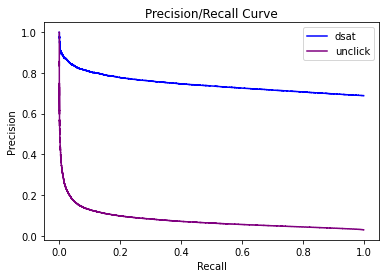

AP1: 0.745471832027236
AP2: 0.07745046100163319


In [32]:
%matplotlib inline
plot_pr(result_df1,result_df2)

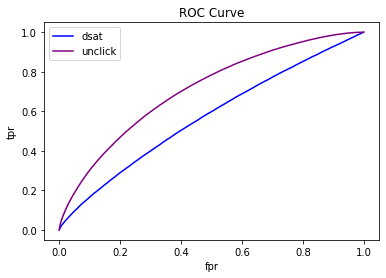

auc1: 0.5711587929775972
auc2: 0.709804640101493


In [33]:
%matplotlib inline
plot_roc(result_df1,result_df2)

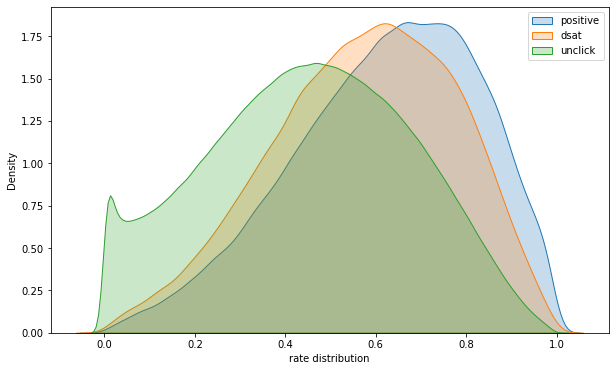

In [34]:
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,6))
plt.xlabel("rate distribution")

sns.kdeplot(data=positive_df["prob1"],shade=True,label="positive")
sns.kdeplot(data=dsat_df["prob1"],shade=True,label="dsat")
sns.kdeplot(data=unclick_df["prob1"],shade=True,label="unclick")
plt.legend()

In [70]:
def prob_counts(df,bins=None):

    prob_array=pd.cut(x=df["prob"],right=False,bins=bins)
    prob_count=prob_array.value_counts().sort_index()
    return prob_count
def get_rate(count1,count2,count3,len_bins):
    sum1,sum2,sum3=sum(count1),sum(count2),sum(count3)
    all_sum=sum1+sum2+sum3
    sum4=all_sum
    rate1,rate2,rate3,rate4=[sum1/all_sum],[sum2/all_sum],[sum3/all_sum],[1]
    for i in range(len_bins-2):
        sum1-=count1[i]
        sum2-=count2[i]
        sum3-=count3[i]
        sum4-=(count1[i]+count2[i]+count3[i])
        rate1.append(sum1/sum4)
        rate2.append(sum2/sum4)
        rate3.append(sum3/sum4)
        rate4.append(sum4/all_sum)
    rate1.append(rate1[-1])
    rate2.append(rate2[-1])
    rate3.append(rate3[-1])
    rate4.append(0)
    return rate1,rate2,rate3,rate4

In [71]:
def getAllRate(prob_path):
    positive_df["prob1"].to_csv(os.path.join(prob_path,"positiveprob"),index=0,header=0)
    dsat_df["prob1"].to_csv(os.path.join(prob_path,"dsatprob"),index=0,header=0)
    unclick_df["prob1"].to_csv(os.path.join(prob_path,"unclickprob"),index=0,header=0)
    dsat_file=os.path.join(prob_path,"dsatprob")
    dsatprob=read_data_file(dsat_file,False,0,head=["prob"])
    dsatprob["prob"]=dsatprob["prob"].astype(float)

    positive_file=os.path.join(prob_path,"positiveprob")
    positiveprob=read_data_file(positive_file,False,0,head=["prob"])
    positiveprob["prob"]=positiveprob["prob"].astype(float)

    unclick_file=os.path.join(prob_path,"unclickprob")
    unclickprob=read_data_file(unclick_file,False,0,head=["prob"])
    unclickprob["prob"]=unclickprob["prob"].astype(float)

    bins=[i*(0.01) for i in range(101)]


    count_dsat=prob_counts(dsatprob,bins=bins).values.tolist()
    count_positive=prob_counts(positiveprob,bins=bins).values.tolist()
    count_unclick=prob_counts(unclickprob,bins=bins).values.tolist()
    rate_positive,rate_dsat,rate_unclick,rate_num=get_rate(count_positive,count_dsat,count_unclick,len(bins))

    rate_clickInAll=np.array(rate_num)*(np.array(rate_dsat)+np.array(rate_positive))
    rate_clickInAll=rate_clickInAll.tolist()

    rate_unclickInAll=np.array(rate_num)*(np.array(rate_unclick))
    rate_unclickInAll=rate_unclickInAll.tolist()

    return rate_positive,rate_dsat,rate_unclick,rate_num,rate_clickInAll,rate_unclickInAll


In [72]:
prob_path0="./special_save/prob"
rate_positive,rate_dsat,rate_unclick,rate_num,rate_clickInAll,rate_unclickInAll=getAllRate(prob_path0)
prob_path1="./special_save/prob1"
rate_positive1,rate_dsat1,rate_unclick1,rate_num1,rate_clickInAll1,rate_unclickInAll1=getAllRate(prob_path1)



In [73]:
bins=[i*(0.01) for i in range(101)]


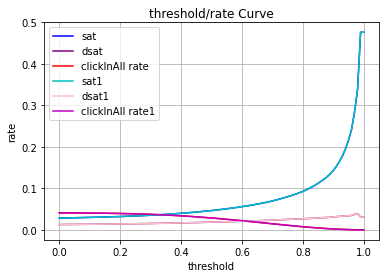

In [74]:
import matplotlib.pyplot as plt

plt.figure("threshold/rate Curve")
plt.title('threshold/rate Curve')
plt.xlabel('threshold')
plt.ylabel('rate')
plt.grid(True)
plt.plot(bins,rate_positive,color="blue",label="sat")
plt.plot(bins,rate_dsat,color="purple",label="dsat")
plt.plot(bins,rate_clickInAll,color="red",label="clickInAll rate")

plt.plot(bins,rate_positive1,color="c",label="sat1")
plt.plot(bins,rate_dsat1,color="pink",label="dsat1")
plt.plot(bins,rate_clickInAll1,color="m",label="clickInAll rate1")
# plt.plot(bins,rate_num,color="red",label="trigger rate")
plt.legend()
plt.show()

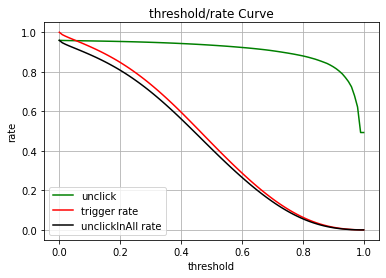

In [62]:
import matplotlib.pyplot as plt

plt.figure("threshold/rate Curve")
plt.title('threshold/rate Curve')
plt.xlabel('threshold')
plt.ylabel('rate')
plt.grid(True)
plt.plot(bins,rate_unclick,color="green",label="unclick")
plt.plot(bins,rate_num,color="red",label="trigger rate")
plt.plot(bins,rate_unclickInAll,color="black",label="unclickInAll rate")

plt.legend()
plt.show()

In [63]:
import numpy as np
temp1=np.array(rate_positive)
temp1=np.round(temp1,3)

temp2=np.array(rate_unclick)
temp2=np.round(temp2,3)

temp3=np.array(rate_dsat)
temp3=np.round(temp3,3)

temp4=np.array(rate_num)
temp4=np.round(temp4,3)

In [64]:
df=pd.DataFrame({"rate_sat":temp1,"rate_unclick":temp2,"rate_dsat":temp3,"rate_trigger":temp4})

In [65]:
df.index=bins

In [67]:
df.iloc[0:30]

,rate_sat,rate_unclick,rate_dsat,rate_trigger
0.00,0.028,0.959,0.013,1.000
0.01,0.029,0.958,0.013,0.988
0.02,0.029,0.958,0.013,0.980
0.03,0.029,0.958,0.013,0.973
0.04,0.029,0.958,0.013,0.967
0.05,0.029,0.957,0.013,0.961
0.06,0.030,0.957,0.013,0.954
0.07,0.030,0.957,0.013,0.948
0.08,0.030,0.957,0.013,0.941
0.09,0.030,0.956,0.014,0.935
